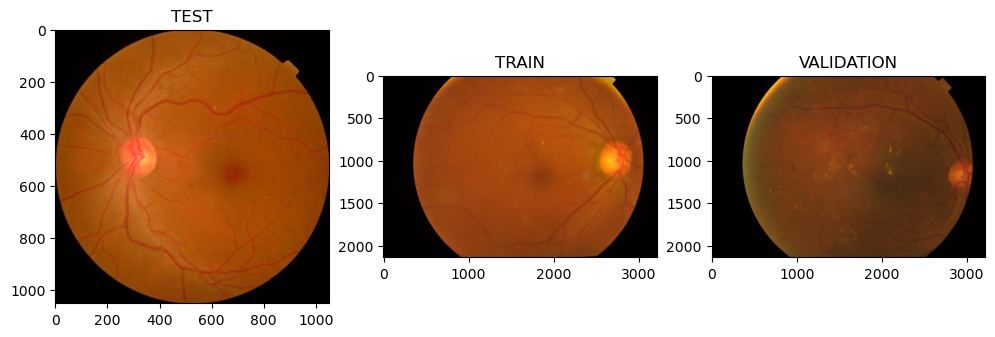

In [1]:
import matplotlib.pyplot as plt
import glob

test_image_path = "./APTOS/test_images/test_images"
train_image_path = "./APTOS/train_images/train_images"
val_image_path = "./APTOS/val_images/val_images"

test_images = sorted(glob.glob(test_image_path + '/*.png'))
train_images = sorted(glob.glob(train_image_path + '/*.png'))
val_images = sorted(glob.glob(val_image_path + '/*.png'))

test_image = test_images[0]
train_image = train_images[0]
val_image = val_images[0]

fig, ax = plt.subplots(1, 3, figsize=(12, 12))

ax[0].imshow(plt.imread(test_image), cmap='gray')
ax[0].set_title('TEST')

ax[1].imshow(plt.imread(train_image), cmap='gray')
ax[1].set_title('TRAIN')

ax[2].imshow(plt.imread(val_image), cmap='gray')
ax[2].set_title('VALIDATION')

plt.show()

In [2]:
import torch
import numpy as np

print(torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

2.4.1
Device: cuda


In [3]:
from typing import Tuple, Any
from functools import lru_cache
from torchvision.datasets import ImageFolder as _ImageFolder

class ImageFolder(_ImageFolder):
    """
    The ImageFolder provided by torchvision reads from memory every time it's
    indexed. Here, we use an LRU cache so that each image is only read from
    memory once. This will require ~1.5 gigabyte of RAM.

    Compared to the naive implementation, this speeds up training ~60x.
    """
    @lru_cache(maxsize = 10_000)
    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target

In [5]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

#TODO: update these values
#target_size = (112, 112)

transform = transforms.Compose([
    # Resize images to 819x614
    transforms.Resize((819,614),interpolation=transforms.InterpolationMode.BICUBIC),
    # Center at 600x600
    transforms.CenterCrop(600),
    # Convert images to tensors
    transforms.ToTensor(),
    # Normalize with ImageNet mean and standard deviation ( a common practice )
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets. Use images under 'train' folder for train_dataset and under 'test' folder for test_dataset
train_dataset = ImageFolder("APTOS/train_images", transform)
val_dataset = ImageFolder("APTOS/val_images", transform)
test_dataset = ImageFolder("APTOS/test_images", transform)


# Create data loaders, use a batch size of '64', set shuffle to 'False' and workers to '0'
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=0)
valid_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


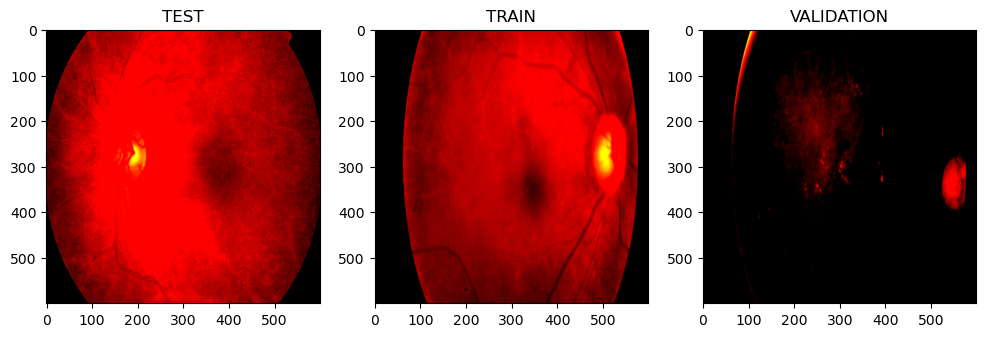

In [7]:
from PIL import Image

# We verify transformation has been applied correctly

test_image_path = "./APTOS/test_images/test_images"
train_image_path = "./APTOS/train_images/train_images"
val_image_path = "./APTOS/val_images/val_images"

test_images = sorted(glob.glob(test_image_path + '/*.png'))
train_images = sorted(glob.glob(train_image_path + '/*.png'))
val_images = sorted(glob.glob(val_image_path + '/*.png'))

# Open images using PIL
test_image = Image.open(test_images[0])
train_image = Image.open(train_images[0])
val_image = Image.open(val_images[0])

# Apply transformations to each image
test_transformed = transform(test_image)
train_transformed = transform(train_image)
val_transformed = transform(val_image)

# Convert transformed tensors back to numpy arrays for plotting
test_transformed = test_transformed.permute(1, 2, 0).numpy()
train_transformed = train_transformed.permute(1, 2, 0).numpy()
val_transformed = val_transformed.permute(1, 2, 0).numpy()

# Plot the transformed images
fig, ax = plt.subplots(1, 3, figsize=(12, 12))

ax[0].imshow(test_transformed)
ax[0].set_title('TEST')

ax[1].imshow(train_transformed)
ax[1].set_title('TRAIN')

ax[2].imshow(val_transformed)
ax[2].set_title('VALIDATION')

plt.show()

In [8]:
from tqdm.auto import tqdm

def verify_loader_size(dataloader, dataset):
    samples = 0
    for batch, labels in tqdm(dataloader):
        samples += len(batch)
    return samples == len(dataset)

# This will take awhile as the images are loaded into memory and cached for the first time.
assert (
    verify_loader_size(train_loader, train_dataset) and
    verify_loader_size(test_loader, test_dataset) and
    verify_loader_size(valid_loader, val_dataset)
)

c:\Users\mauri\anaconda3\envs\cuda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 6/6 [00:48<00:00,  8.11s/it]


In [9]:
# Notice how much faster it is after caching!
assert (
    verify_loader_size(train_loader, train_dataset) and
    verify_loader_size(test_loader, test_dataset) and
    verify_loader_size(valid_loader, val_dataset)
)

100%|██████████| 6/6 [00:00<00:00, 26.58it/s]


In [11]:
from tqdm import tqdm


def train_model(model, loss_module, optimizer, train_loader, valid_loader, device, path='model', epochs=20):
    training_losses = []
    validation_losses = []

    for epoch in range(epochs):
        # Set model to train mode
        model.train()

        running_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Training epoch {epoch + 1}/{epochs}", leave=False, unit='mini-batch')
        best_val_loss = float('inf')
        # Batch loop
        for inputs, labels in progress_bar:

            # Move input data to device (only strictly necessary if we use GPU)
            inputs, labels = inputs.to(device), labels.to(device)

            # Before calculating the gradients, we need to ensure that they are all zero.
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad()

            # Run the model on the input data and compute the outputs
            outputs = model(inputs)

            # Calculate the loss
            loss = loss_module (outputs, labels)

            # Perform backpropagation
            loss.backward()
            # Update the parameters
            optimizer.step()
            # Calculate the loss for current iteration
            running_loss += loss.item()

            progress_bar.set_postfix(loss=loss.item())

        train_loss = running_loss/len(train_loader)

        # Set model to eval mode for validation
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                # For validation batches, calculate the output, and loss in a similar way
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model (inputs)
                loss = loss_module(outputs, labels)
                running_loss += loss.item()

        valid_loss = running_loss/len(valid_loader)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f},  Valid Loss: {valid_loss:.4f}')
        if valid_loss < best_val_loss:
            best_val_loss = valid_loss
            best_epoch = epoch+1
            torch.save(model.state_dict(), path+ f"_best.tar")
        # Save the model's state_dict at end of each epoch
        torch.save(model.state_dict(), path + f".tar")

        training_losses.append(train_loss)
        validation_losses.append(valid_loss)

    return training_losses, validation_losses

In [12]:
def plot_learning_curves(training_losses, validation_losses):
    # Plot epoch wise training and validation losses (both in the same plot)
    assert len(training_losses) == len(validation_losses)

    # YOUR CODE HERE
    plt.figure(figsize=(10,6))
    plt.plot(training_losses, label='Training Loss', color='blue', marker='o')
    plt.plot(validation_losses, label='Validation Loss', color='orange', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.show()

# Shallow CNN

In [15]:
from torch import nn

class CNNShallow(nn.Module):
    def __init__(self, input_shape=(600, 600, 3)):  # Updated input shape to match resized images
        super(CNNShallow, self).__init__()

        # Convolutional and pooling layers
        self.conv1 = nn.Conv2d(in_channels=input_shape[2], out_channels=64, kernel_size=(3,3), padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=(4,4), stride=2)

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(4,4), stride=2)

        # Compute the flattened feature size
        self._flattened_size = self._get_flattened_size(input_shape)

        # Fully connected layer, adjusted with computed flattened size
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(self._flattened_size, 2)

    def _get_flattened_size(self, input_shape):
        # Helper method to calculate size after convolution and pooling layers
        dummy_input = torch.zeros(1, input_shape[2], input_shape[0], input_shape[1])
        x = self.conv1(dummy_input)
        x = self.pool1(self.relu1(x))
        x = self.conv2(x)
        x = self.pool2(self.relu2(x))
        return x.numel()  # Calculate total elements

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

# Instantiate the model
cnn_model = CNNShallow(input_shape=(600, 600, 3))

print(cnn_model)

CNNShallow(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=1401856, out_features=2, bias=True)
)


In [17]:
from torchsummary import summary

summary(cnn_model, (3, 600, 600), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 600, 600]           1,792
              ReLU-2         [-1, 64, 600, 600]               0
         MaxPool2d-3         [-1, 64, 299, 299]               0
            Conv2d-4         [-1, 64, 299, 299]          36,928
              ReLU-5         [-1, 64, 299, 299]               0
         MaxPool2d-6         [-1, 64, 148, 148]               0
           Flatten-7              [-1, 1401856]               0
            Linear-8                    [-1, 2]       2,803,714
Total params: 2,842,434
Trainable params: 2,842,434
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 4.12
Forward/backward pass size (MB): 503.91
Params size (MB): 10.84
Estimated Total Size (MB): 518.87
----------------------------------------------------------------


In [18]:
cnn_model.to(device)

loss_module = torch.nn.CrossEntropyLoss()

# You can use '0.0001' as learning rate for the optimizer
optimizer = torch.optim.Adam(params = cnn_model.parameters(), lr=0.0001)

training_losses, validation_losses = train_model(
    cnn_model, loss_module, optimizer, train_loader, valid_loader, device, 'cnn-shallow'
)
plot_learning_curves(training_losses, validation_losses)

Epoch 1/20, Train Loss: 0.0159,  Valid Loss: 0.0000


KeyboardInterrupt: 

# Testing

In [ ]:
from sklearn.metrics import roc_curve, auc

def test_model(model, test_loader):

    true_labels = []

    # predicted probabilities have probability that a sample belongs to positive class (having pneumonia)
    predicted_probabilities = []

    # Set model to eval mode
    model.eval()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Get the predicted class indices
            _, predicted = torch.max(outputs,1)

            true_labels.extend(labels.cpu().numpy())

            # Compute softmax probabilities for each class and select the probability of the positive class
            probs = torch.softmax(outputs, dim=1)[:,1]

            predicted_probabilities.extend(probs.cpu().numpy())

    return true_labels, predicted_probabilities

def plot_roc_curve(labels, probs):

    # Compute and plot the ROC curve and specify the AUC value in the legend (or within the plot somewhere).
    fpr, tpr, thresholds = roc_curve(labels, probs)
    auc_val = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'AUC = {auc_val:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line for random guessing
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()


In [ ]:
# Load the model from the epoch you deem optimal

cnn_model = CNNShallow()
cnn_model.load_state_dict(torch.load("cnn-shallow_best.tar"))
cnn_model.to(device)

true_labels, predicted_probabilities = test_model(cnn_model, test_loader)

assert(len(true_labels) == len(predicted_probabilities))

In [ ]:
plot_roc_curve(true_labels, predicted_probabilities)